In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Metrics and other evaluators
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

# Pipeline and related
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler



/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Data source

https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/

Includes feature descriptions, which informed some of my wrangling decisions (eg, dropping the "station" features)

You are provided the following set of information on a (`year, weekofyear`) timescale:

(Where appropriate, units are provided as a `_unit` suffix on the feature name.)

*City and date indicators*
* `city` – City abbreviations: sj for San Juan and iq for Iquitos
* `week_start_date` – Date given in yyyy-mm-dd format

*NOAA's GHCN daily climate data weather station measurements*
* `station_max_temp_c` – Maximum temperature
* `station_min_temp_c` – Minimum temperature
* `station_avg_temp_c` – Average temperature
* `station_precip_mm` – Total precipitation
* `station_diur_temp_rng_c` – Diurnal temperature range

*PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)*
* `precipitation_amt_mm` – Total precipitation

*NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)*
* `reanalysis_sat_precip_amt_mm` – Total precipitation
* `reanalysis_dew_point_temp_k` – Mean dew point temperature
* `reanalysis_air_temp_k` – Mean air temperature
* `reanalysis_relative_humidity_percent` – Mean relative humidity
* `reanalysis_specific_humidity_g_per_kg` – Mean specific humidity
* `reanalysis_precip_amt_kg_per_m2` – Total precipitation
* `reanalysis_max_air_temp_k` – Maximum air temperature
* `reanalysis_min_air_temp_k` – Minimum air temperature
* `reanalysis_avg_temp_k` – Average air temperature
* `reanalysis_tdtr_k` – Diurnal temperature range

*Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements*
* `ndvi_se` – Pixel southeast of city centroid
* `ndvi_sw` – Pixel southwest of city centroid
* `ndvi_ne` – Pixel northeast of city centroid
* `ndvi_nw` – Pixel northwest of city centroid

## Import Data

In [2]:
cd /Users/localadmin/Documents/BloomTech/Unit_2/Datasets/Dengue

/Users/localadmin/Documents/BloomTech/Unit_2/Datasets/Dengue


In [3]:
ls

dengue_features_test.csv   dengue_labels_train.csv
dengue_features_train.csv


## Preliminary EDA

Exploring the original data to figure out how it should be wrangled. Looking for issues such as:

*   Constant columns
*   High cardinality categoricals
* Date time info
* Redundant/correlated columns
* Null values
* Distribution of target feature (total_cases)
* Etc

In [52]:
df = pd.merge(pd.read_csv("dengue_features_train.csv", parse_dates = True), 
              pd.read_csv("dengue_labels_train.csv", parse_dates = True))
df.set_index("week_start_date", inplace = True) # set start date as index
df.sort_index(inplace=True)

In [53]:
df.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1456 entries, 1990-04-30 to 2010-06-25
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   ndvi_ne                                1262 non-null   float64
 4   ndvi_nw                                1404 non-null   float64
 5   ndvi_se                                1434 non-null   float64
 6   ndvi_sw                                1434 non-null   float64
 7   precipitation_amt_mm                   1443 non-null   float64
 8   reanalysis_air_temp_k                  1446 non-null   float64
 9   reanalysis_avg_temp_k                  1446 non-null   float64
 10  reanalysis_dew_point_temp_k            1446 non-null   float64

### Evaluate distribution of observations to determine train/test split

In [55]:
df["year"].value_counts().sort_index()

1990     35
1991     52
1992     52
1993     52
1994     52
1995     52
1996     52
1997     52
1998     52
1999     52
2000     78
2001    104
2002    104
2003    104
2004    104
2005    104
2006    104
2007    104
2008     69
2009     52
2010     26
Name: year, dtype: int64

Total observations: 1456

Train cutoff: 2004 (893 observations, about 61%)

Validate cutoff: 2007 (312 observations, about 21%)

Test set: 2008–2010 (251 observations, about 17%)

### Evaluate distribution of target feature (total_cases)

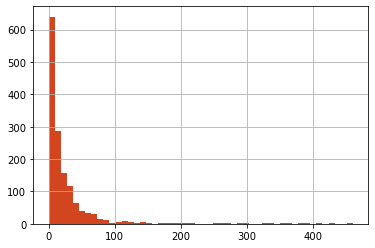

In [56]:
df["total_cases"].hist(bins=50, color="#d2451e");

Target is right skewed

### Confirming that "station" temperature measurements are equivalent to "reanalysis" temp measurements
Convert kelvins from reanalysis temps to celcius in order to compare station measurements

*Formula to convert kelvins to celcius is K - 273.15*

In [57]:
df["max_air_temp_c"] = df["reanalysis_max_air_temp_k"] - 273.15
df[["max_air_temp_c", "station_max_temp_c"]]

,max_air_temp_c,station_max_temp_c
week_start_date,,
1990-04-30,26.65,29.4
1990-05-07,27.75,31.7
1990-05-14,27.35,32.2
1990-05-21,28.25,33.3
1990-05-28,28.75,35.0
...,...,...
2010-05-28,36.55,35.4
2010-06-04,35.35,34.7
2010-06-11,32.35,32.2


Converted "reanalysis_max_air_temp_k" is close enough to "station_max_temp_c" that I feel comfortable considering the "station" measurements redundant

### Deciding which columns to drop
All of the `station` measruements appear to be repeated in the `reanalysis` measurements (difference is units, celcius vs. kelvins)
* `station_max_temp_c`
* `station_min_temp_c`
* `station_avg_temp_c`
* `station_precip_mm`
* `station_diur_temp_rng`

`precipitation_amt_mm` appears to be identical to `reanalysis_stat_precip_amt_mm`. Choosing to keep `reanalysis_stat_precip_atm_mm`, as I will be keeping the "reanalysis" data for other measurements


*Should `year` column be dropped?* It would behave like an integer here, and I could imagine that it could have an impact on case numbers (eg, climate change). But if the impact of year is because of climate changes, then the temperature features would account for that change (ie, if the impact of time passing/climate change is that the weather impacts case numbers, all of the weather data recorded would be sufficient). *Ultimately have decided to drop the `year` column*

In [58]:
print(df[["precipitation_amt_mm", "reanalysis_sat_precip_amt_mm"]].nunique())
df[["precipitation_amt_mm", "reanalysis_sat_precip_amt_mm"]].head()

precipitation_amt_mm            1157
reanalysis_sat_precip_amt_mm    1157
dtype: int64


,precipitation_amt_mm,reanalysis_sat_precip_amt_mm
week_start_date,,
1990-04-30,12.42,12.42
1990-05-07,22.82,22.82
1990-05-14,34.54,34.54
1990-05-21,15.36,15.36
1990-05-28,7.52,7.52


`reanalysis_precip_amt_kg_per_m2` is total precipation in a different unit (1kg/m^2 is equivalent to 1mm precipitation); potentially should also be dropped

**Comparing `relative_humidity_percent` to `specific_humidty_g_per_kg` to check for redundancy:**

In [59]:
print(df[["reanalysis_relative_humidity_percent", 
          "reanalysis_specific_humidity_g_per_kg"]].nunique())
df[["reanalysis_relative_humidity_percent", 
    "reanalysis_specific_humidity_g_per_kg"]].tail()

reanalysis_relative_humidity_percent     1370
reanalysis_specific_humidity_g_per_kg    1171
dtype: int64


,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg
week_start_date,,
2010-05-28,88.765714,18.485714
2010-06-04,91.600000,18.070000
2010-06-11,94.280000,17.008571
2010-06-18,94.660000,16.815714
2010-06-25,89.082857,17.355714


These columns do not appear to be as similar in values as I had expected. 

After researching the two kinds of measures, I found that:
* Relative humidity is a function of both water content and temp, or the percent of moisture the air is holding relative to the maximum humidity possible for that temperature
* Specific humidity is the ratio of the mass of water vapor in an air parcel to the mass of dry air for the same parcel

Have decided to keep both columns until checking for feature/permutation importance

**Comparing `reanalysis_air_temp_k` and `reanalysis_avg_temp_k`**

In the descriptions from the data source, these two columns are described as "mean air temp" and "average air temp", respectively. I would expect them to be very similar. 

In [12]:
print(df[["reanalysis_air_temp_k", "reanalysis_avg_temp_k"]].nunique())
df[["reanalysis_air_temp_k", "reanalysis_avg_temp_k"]].tail()

reanalysis_air_temp_k    1176
reanalysis_avg_temp_k     600
dtype: int64


,reanalysis_air_temp_k,reanalysis_avg_temp_k
week_start_date,,
2010-05-28,299.334286,300.771429
2010-06-04,298.330000,299.392857
2010-06-11,296.598571,297.592857
2010-06-18,296.345714,297.521429
2010-06-25,298.097143,299.835714


They look very similar when looking at the head/tail. Not sure why `reanalysis_avg_temp_k` has about half the unique values as `reanalysis_air_temp_k`.

Choosing to keep the richer column of `reanalysis_air_temp_k`

**Exploring where `total_cases` is 0**

I need to transform the `total_cases` column, as it is heavily right skewed. However, performing a log function on the column raised errors, as log 0 is undefined. Considering how to handle the observations with 0 `total_cases`

In [60]:
mask = df["total_cases"] == 0
print(df[mask]["total_cases"].value_counts())
100/1456

df[mask]["city"].value_counts()

0    100
Name: total_cases, dtype: int64


iq    96
sj     4
Name: city, dtype: int64

In [61]:
df.shape
100/1456

0.06868131868131869

Observations of zero cases amount to ~ 7% of all observations.

Most of the observations of 0 `total_cases` occur in Iquitos

**Final list of columns to drop:**

* `station_max_temp_c`
* `station_min_temp_c`
* `station_avg_temp_c`
* `station_precip_mm`
* `station_diur_temp_rng`
* `precipitation_amt_mm`
* `reanalysis_sat_precip_amt_mm`
* `reanalysis_relative_humidity_percent`
* `reanalysis_avg_temp_k`
* `year`
* `total_cases`

*Dropped after calculating permutation importance*
* `relative_humidity_percent`
* `sat_precip_amt_mm`

## Wrangling

In [73]:
def wrangle(features, labels = None):
    if labels:
        df = pd.merge(pd.read_csv(features, parse_dates=True), 
                      pd.read_csv(labels, parse_dates=True))
    else:
        df = pd.read_csv(features, parse_dates=True)

    df.set_index("week_start_date", inplace=True) # set start date as index
    df.sort_index(inplace=True)

    #———————————————————————
    # Encode city (1 = San Juan, 0 = Iquitos)
    df["city"] = (df["city"] == "sj").astype(int)

    #———————————————————————
    # Take care of skewed target column
    # apply log to total_cases, then drop total_cases to prevent leakage;
      # log of 0 was causing problems (log 0 is undefined),
      # so imputing as 0 for best approximation
      # May explore dropping observations with 0 total_cases
    df["total_cases_log"] = df.apply(lambda x: 0 if (x["total_cases"] == 0) 
                                     else np.log(x["total_cases"]), axis=1)

    #———————————————————————
    # DROPPING COLUMNS
    # add all of the "station" measurements to drop list
    # (too much overlap with the reanalysis columns)
    col_names = df.columns
    cols_to_drop = [col for col in col_names if "station" in col]

    # add some redundant precipitation columns and year column to drop
    cols_to_drop.extend(["precipitation_amt_mm", "reanalysis_avg_temp_k", 
                        "year", "total_cases", "reanalysis_sat_precip_amt_mm",
                        "reanalysis_relative_humidity_percent"])
                      
                        # last two columns added to drop list after calculating
                        # permutation importance

    # drop the columns in cols_to_drop list
    df.drop(columns=cols_to_drop, inplace=True)

    #———————————————————————
    # SIMPLIFY COLUMN NAMES
    col_names = df.columns

    # remove "reanalysis_" prefix
    col_names = [x.replace("reanalysis_", "") for x in col_names]

    # adjust other column names for clarity/simplicity
    # (reassigning the names in the col_names list)
    col_names[col_names.index("weekofyear")] = "year_week"
    col_names[col_names.index("air_temp_k")] = "mean_air_temp_k"
    col_names[col_names.index("tdtr_k")] = "diurn_temp_rng_k"
    # [DROPPED BELOW TWO COLUMNS AFTER CALCULATING PERMUTATION IMPORTANCE]
    # col_names[col_names.index("relative_humidity_percent")] = "relative_humidity_pct"  
    # col_names[col_names.index("sat_precip_amt_mm")] = "precipitation_mm"

    # Use col_names list to reassign column names
    df.columns = col_names

    #———————————————————————
    return df

In [77]:
df = wrangle("dengue_features_train.csv", "dengue_labels_train.csv")

In [64]:
df.head()

,city,year_week,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,mean_air_temp_k,dew_point_temp_k,max_air_temp_k,min_air_temp_k,precip_amt_kg_per_m2,specific_humidity_g_per_kg,diurn_temp_rng_k,total_cases_log
week_start_date,,,,,,,,,,,,,,
1990-04-30,1,18,0.122600,0.103725,0.198483,0.177617,297.572857,292.414286,299.8,295.9,32.00,14.012857,2.628571,1.386294
1990-05-07,1,19,0.169900,0.142175,0.162357,0.155486,298.211429,293.951429,300.9,296.4,17.94,15.372857,2.371429,1.609438
1990-05-14,1,20,0.032250,0.172967,0.157200,0.170843,298.781429,295.434286,300.5,297.3,26.10,16.848571,2.300000,1.386294
1990-05-21,1,21,0.128633,0.245067,0.227557,0.235886,298.987143,295.310000,301.4,297.0,13.90,16.672857,2.428571,1.098612
1990-05-28,1,22,0.196200,0.262200,0.251200,0.247340,299.518571,295.821429,301.9,297.5,12.20,17.210000,3.014286,1.791759


## Plots

In [20]:
colors = {1: "#d2451e", 0: "#b1c4e3"}

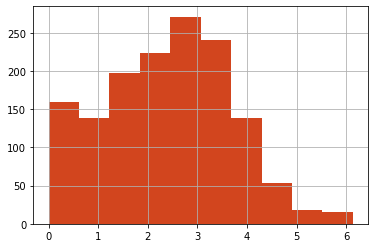

In [65]:
df["total_cases_log"].hist(color="#d2451e");

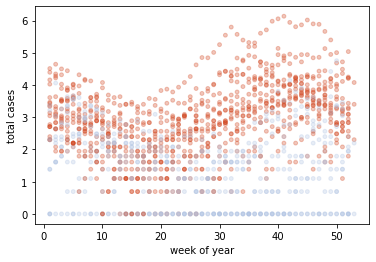

In [66]:
plt.scatter(df["year_week"], df["total_cases_log"], c=df["city"].map(colors), alpha=0.3, s=15);
plt.xlabel("week of year");
plt.ylabel("total cases");

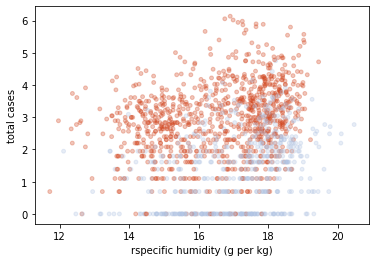

In [67]:
plt.scatter(df["specific_humidity_g_per_kg"], df["total_cases_log"], c=df["city"].map(colors), alpha=0.3, s=15);
plt.xlabel("rspecific humidity (g per kg)");
plt.ylabel("total cases");

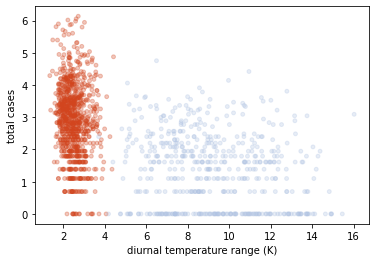

In [68]:
plt.scatter(df["diurn_temp_rng_k"], df["total_cases_log"], c=df["city"].map(colors), alpha=0.3, s=15);
plt.xlabel("diurnal temperature range (K)");
plt.ylabel("total cases");

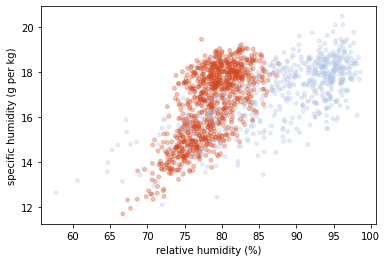

In [72]:
plt.scatter(df["relative_humidity_pct"], df["specific_humidity_g_per_kg"], c=df["city"].map(colors), alpha=0.3, s=15);
plt.xlabel("relative humidity (%)");
plt.ylabel("specific humidity (g per kg)");

## Split data

Split data into feature matrix and target vector

In [78]:
target = "total_cases_log"
X = df.drop(columns = target)
y = df[target]

Only splitting into train/test, as I will be using automated cross-validation methods

In [79]:
cutoff = "2007"

mask = X.index < cutoff

X_train, y_train = X[mask], y[mask]
X_test, y_test = X[~mask], y[~mask]

Confirm the lengths of X_train and y_train match

In [80]:
print(X_train.shape)
print(y_train.shape)

(1205, 13)
(1205,)


Confirm the lengths of X_test and y_test match

In [81]:
print(X_test.shape)
print(y_test.shape)

(251, 13)
(251,)


## Establish baseline

Use mean as baseline predictions

In [82]:
y_mean = y_train.mean()
y_pred = [y_mean] * len(y_train)

Calculate Baseline MAE (in same unit of measurement as target)

In [83]:
baseline_mae = mean_absolute_error(y_train, y_pred)
print("Baseline MAE:", baseline_mae)

Baseline MAE: 1.0791371095679734


## Build models

### XGBoost

Build XGBoost Regressor pipeline

In [84]:
model_xgb = make_pipeline(
    SimpleImputer(),
    XGBRegressor(random_state=42, n_estimators=75, n_jobs=-1)
)

Set up dictionary of hyperparameters for RandomizedSearchCV

In [86]:
param_grid = {
    "simpleimputer__strategy": ["mean", "median"],
    # set a range for depth between 5 and 50, increasing in increments of 5
    "xgbregressor__max_depth": range(5, 50, 5),
    # set a range for number of trees between 25 and 150, increasing in increments of 25
    "xgbregressor__n_estimators": range(25, 150, 25)
}

Set up a hyperparameter search using RandomizedSearchCV

In [87]:
model_xgb_rs = RandomizedSearchCV(
    model_xgb,
    param_distributions=param_grid,
    n_jobs=-1,
    # number of hyperparameter candidates from param_grid to test out
    n_iter=10,
    # how many cross validation folds to make
    cv=5,
    # specifying MAE as scoring metric—sklearn requires negative MAE here
    scoring="neg_mean_absolute_error",
    verbose=1,
    random_state=42
)

model_xgb_rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inste

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           enable_categorical=False,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                      

Calculate training MAE and compare to baseline MAE

*Model performs slightly better than baseline*

In [88]:
# take the absolute value of the negative MAE in order to compare to baseline MAE
train_mae_xgb = abs(model_xgb_rs.best_score_) 
print("Train MAE:", train_mae_xgb)
print("Baseline MAE:", baseline_mae)

Train MAE: 0.9592283028673417
Baseline MAE: 1.0791371095679734


### Random Forest

Build Random Forest pipeline

In [89]:
model_rf = make_pipeline(
    SimpleImputer(),
    RandomForestRegressor(random_state=42, n_estimators=75, n_jobs=-1)
)

Set up dictionary of hyperparameters for RandomizedSearchCV

In [90]:
param_grid = {
    "simpleimputer__strategy": ["mean", "median"],
    # set a range for depth between 5 and 50, increasing in increments of 5
    "randomforestregressor__max_depth": range(5, 50, 5),
    # set a range for number of trees between 25 and 150,
    # increasing in increments of 25
    "randomforestregressor__n_estimators": range(25, 150, 25)
}

Set up a hyperparameter search using RandomizedSearchCV

In [91]:
model_rf_rs = RandomizedSearchCV(
    model_rf,
    param_distributions = param_grid,
    n_jobs=-1,
    # number of hyperparameter candidates from param_grid to test out
    n_iter=10,
    # how many cross validation folds to make
    cv=5,
    # specifying MAE as scoring metric—-sklearn requires negative MAE here
    scoring="neg_mean_absolute_error",
    verbose=1,
    random_state=42
)

model_rf_rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(n_estimators=75,
                                                                    n_jobs=-1,
                                                                    random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(5, 50, 5),
                                        'randomforestregressor__n_estimators': range(25, 150, 25),
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [92]:
# take the absolute value of the negative MAE in order to compare to baseline MAE
train_mae_rf = abs(model_rf_rs.best_score_) 

# predict using model, check against test
test_mae = mean_absolute_error(y_test, model_rf_rs.predict(X_test))

# print results
print("Train MAE:", train_mae_rf)
print("Test MAE:", test_mae)
print("Baseline MAE:", baseline_mae)

Train MAE: 0.8943385649281312
Test MAE: 0.8810702939398753
Baseline MAE: 1.0791371095679734


Calculate training and test MAE, compare to baseline MAE

*Random Forest model performs slightly better than baseline, as well as XGBoost model*

*Test MAE is similar to train MAE; appears model generalizes fairly well*

*Before dropping `precipitation_mm` and `relative_humidity_pct`*
* *Train MAE: 0.8992027213788887*
* *Baseline MAE: 1.0791371095679734*


In [ ]:
# If i was returning a series of predictions, would need to transform them, as i took the log of the total_cases

### Communicate results

Random Forest Feature Importance (prior to dropping `reanalysis_sat_precip_amt_mm` and `reanalysis_relative_humidity_percent`)

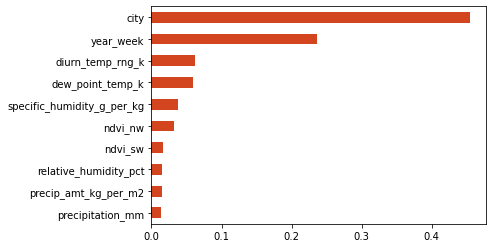

In [41]:
bestestimator = model_rf_rs.best_estimator_
importances = bestestimator.named_steps["randomforestregressor"].feature_importances_

feature_names = X_train.columns 
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()

feat_imp.tail(10).plot(kind="barh", color=colors[1]);

Random Forest Permutation importance (prior to dropping `reanalysis_sat_precip_amt_mm` and `reanalysis_relative_humidity_percent`)

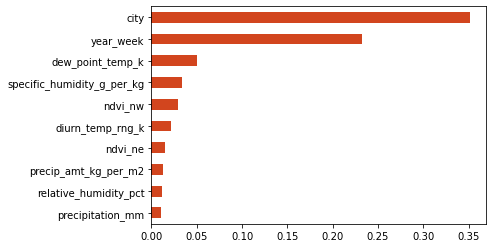

In [42]:
# Calculate permutation importances
perm_imp = permutation_importance(model_rf_rs, X_train, y_train)

# create data frame with permutation importance means and stds
data_perm = {"imp_mean": perm_imp["importances_mean"],
             "imp_std": perm_imp["importances_std"]}

df_perm = pd.DataFrame(data_perm, index = X_train.columns).sort_values("imp_mean") # sort values by mean

# Graph the permutation importance
df_perm["imp_mean"].tail(10).plot(kind="barh", color=colors[1]);

In [43]:
df_perm

,imp_mean,imp_std
max_air_temp_k,0.003873,0.000745
mean_air_temp_k,0.006266,0.000530
min_air_temp_k,0.006286,0.000605
ndvi_se,0.008900,0.000916
ndvi_sw,0.009486,0.000528
precipitation_mm,0.010145,0.001258
relative_humidity_pct,0.011241,0.001285
precip_amt_kg_per_m2,0.012365,0.003102
ndvi_ne,0.015038,0.001614
diurn_temp_rng_k,0.021377,0.005636


In first pass, appeared that `precip_amt_kg_per_m2` and `precipitation_mm` were both fairly unimportant and had similar permutation/feature importances, with `precipitation_mm` being less important 

`specific_humidity_g_per_kg` appeared to have more importance than relative_humidity_pct

Went back to wrangle function to drop `precipitation_mm` and `relative_humidity_pct`

*I'm interested in seeing how things would change if I dropped all of the Iquitos data*

## Note


assignment instructions:

https://bloomtech.instructure.com/courses/2065/pages/advanced-assignment?module_item_id=642115